In [1]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
PARAM = dict()
PARAM['features'] = 300
PARAM['lr'] = 0.01
PARAM['epochs'] = 301
PARAM['weight_decay'] = 0.02
PARAM['stopping'] = 0.001
PARAM['mode'] = 'svd++'

PARAM['path'] = {
  'ml':'./data/MovieLens25M/'
}

In [3]:
ML_25M = {}
hasReindex = True
try:
  ML_25M['ratings'] = pd.read_csv(PARAM['path']['ml']+'ratings_newMovieId_no_index.csv')
except:
  hasReindex = False
  ML_25M['ratings'] = pd.read_csv(PARAM['path']['ml']+'ratings.csv')

ML_25M['movies'] = pd.read_csv(PARAM['path']['ml']+'movies.csv')

ML_25M['movies'].insert(1, 'newMovieId', value=range(1,len(ML_25M['movies'])+1))
newMovieIdDict = {}
for index, movie in ML_25M['movies'].iterrows():
    newMovieIdDict[movie['movieId']] = movie['newMovieId']

if not hasReindex:
  ML_25M['ratings_reindex'] = ML_25M['ratings']

  for index, rating in ML_25M['ratings'].iterrows():
    if index % 1000000 == 0: print('{}/{}'.format(index, len(ML_25M['ratings'])))
    ML_25M['ratings_reindex'].at[index, 'movieId'] = newMovieIdDict[rating['movieId']]

  ML_25M['ratings_reindex'].to_csv(PARAM['path']['ml']+'ratings_newMovieId_no_index.csv', index = False)

  ML_25M['ratings'] = ML_25M['ratings_reindex']

ML_25M['movies'].drop(columns=['movieId'], inplace=True)
ML_25M['movies'].rename(columns={"newMovieId": "movieId"}, inplace=True)

ML_25M['ratings'] = ML_25M['ratings'].sort_values(by=['userId'])
ML_25M['movies'] = ML_25M['movies'].sort_values(by=['movieId'])

In [4]:
maxNumberOfUser = 50000
maxNumberOfMovie = 20000

maxNumberOfReview = ML_25M['ratings'][ML_25M['ratings']['userId'] == maxNumberOfUser].index[-1]
ML_25M['ratings'] = ML_25M['ratings'][:maxNumberOfReview]

ML_25M['movies'] = ML_25M['movies'][:maxNumberOfMovie]

# inner join by movieId
ML_25M['ratings'] = ML_25M['ratings'].merge(ML_25M['movies'], on='movieId')[['userId', 'movieId', 'rating']]
ML_25M['ratings']

ML_25M['m_movies'] = ML_25M['movies']['movieId'].nunique()
ML_25M['n_users'] = ML_25M['ratings']['userId'].nunique()
ML_25M['n_ratings'] = len(ML_25M['ratings'])

ML_25M['ratings']['userId'] = ML_25M['ratings']['userId'].astype(np.int32)
ML_25M['ratings']['movieId'] = ML_25M['ratings']['movieId'].astype(np.int32)
ML_25M['ratings']['rating'] = ML_25M['ratings']['rating'].astype(np.float32)

ML_25M

{'ratings':          userId  movieId  rating
 0             1      293     5.0
 1             3      293     5.0
 2             4      293     4.0
 3             5      293     4.0
 4             7      293     4.0
 ...         ...      ...     ...
 7213863   49403     5033     0.5
 7213864   49631    19610     4.0
 7213865   49879    19188     0.5
 7213866   49901    19862     1.0
 7213867   49901    17840     1.0
 
 [7213868 rows x 3 columns],
 'movies':        movieId                                        title  \
 0            1                             Toy Story (1995)   
 1            2                               Jumanji (1995)   
 2            3                      Grumpier Old Men (1995)   
 3            4                     Waiting to Exhale (1995)   
 4            5           Father of the Bride Part II (1995)   
 ...        ...                                          ...   
 19995    19996                                 Joker (2012)   
 19996    19997             

In [5]:
print(ML_25M['ratings'].shape)
print(ML_25M['movies'].shape)

(7213868, 3)
(20000, 3)


In [6]:
print('Creating SVD Model')
svd = SVDModel()
print("Created\nLoading Data")
svd.data_loader(data=ML_25M['ratings'], 
                n_items = ML_25M['m_movies'], 
                n_users= ML_25M['n_users'])

print("Loaded Data\nSpliting Data")
svd.split(0.8,0.8)
print("Splitted Data")

Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: (49994, 18904)
User Reference length: 49994
Item Reference length: 18904
Splitted Data


In [7]:
def train_model(features, lr, epochs, weight_decay, mode):
    print("Training")
    # if os.path.isfile(f'./model_movielens/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl'):
    #     return
    print(f"==============================")
    # print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: {weight_decay}\nstopping: 0.001\n')
    print(f'features: {svd.features}\nlearning rate: {svd.lr}\nEpochs: {svd.epochs}\nweight decay: {svd.weight_decay}\nstopping: {svd.stopping}\n')

 
    svd.features = features
    svd.lr = lr
    svd.epochs = epochs
    svd.weight_decay = weight_decay
    svd.mode = mode
    svd.stopping = PARAM['stopping']
 

    print("Splitted Data\nTraining...")
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
   
    print('Saving Model')
    Path(f"./model_movielens").mkdir(parents=True, exist_ok=True)
    Path(f"./model_movielens/svdpp").mkdir(parents=True, exist_ok=True)
    Path(f"./model_movielens/svdpp/model").mkdir(parents=True, exist_ok=True)
    Path(f"./model_movielens/svdpp/result").mkdir(parents=True, exist_ok=True)
   
   
    # with open(f'./model_movielens/svdpp/model/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
    #     pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
    #     out.close()
    with open(f'./model_movielens/svdpp/result/{features}_{lr}_{epochs}_{weight_decay}_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
        out.close()
    print(f"==============================")
    return svd, result

In [8]:
res_svd, result = train_model(PARAM['features'],PARAM['lr'],PARAM['epochs'],PARAM['weight_decay'],PARAM['mode'] ) 

Training
features: 5
learning rate: 0.01
Epochs: 101
weight decay: 0.02
stopping: 0.001

Splitted Data
Training...
Epoch :    1  | Train : 0.808  | Valid : 0.828  | Time : 10.22212s
Epoch :   11  | Train : 0.340  | Valid : 0.621  | Time : 30.01503s
Training stopped:
Epoch :   13  | Train Loss : 0.279  | Valid Loss: 0.620  | Test Loss: 0.618
Time used = 49.53349449999999
Saving Model


In [9]:
# load result
if os.path.isfile(f"./model_movielens/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl"):
  # with open(f"./model_movielens/svdpp/model/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
  #   svd = pickle.load(inp)
  #   inp.close()
  with open(f"./model_movielens/svdpp/result/{PARAM['features']}_{PARAM['lr']}_{PARAM['epochs']}_{PARAM['weight_decay']}_0.001.pkl", 'rb') as inp:
    result = pickle.load(inp)
    print(result[0][-1])
    print(result[1][-1])
    print(result[2])
    print(len(result[0]))
    inp.close()
    

0.2791537355112236
0.6200949522339392
0.6178984940371097
13


In [10]:
from SVDModel import topKPrediction,movieRatePredictionByUserIdMovieId, makePrediction, findThreshold

### Definition of Relevant and Recommended

* Relevant: True Rating `>=` threshold
* Irrelevant: True Rating `<` threshold
* Recommended item: Predicted Rating `>=` threshold
* Not Recommended item: Predicted Rating `<` threshold

In [11]:
userIds, movieIds, actuals, predictions = makePrediction(svd.n_users, svd.n_items, svd.test, 
                                                         svd.users_ref, svd.movies_ref, svd.mode, 
                                                         svd._P, svd._Q, svd._mean, svd._bu, svd._bi)

predictions = {
  'userId':list(userIds),
  'movieId':list(movieIds),
  'actual':list(actuals),
  'prediction':list(predictions)
}

df = pd.DataFrame(predictions)

In [36]:
df.head()

,userId,movieId,actual,prediction
0,1,1228,3.5,4.103152
1,1,2072,3.5,3.314869
2,1,2483,4.0,3.488487
3,1,3471,5.0,3.619803
4,1,4599,4.0,3.670890


In [13]:
# Find a threshold
thresholds = np.arange(0,5.1,0.5)
res = {
  'precision':[],
  'recall':[],
  'F1':[]
}
 
# from numba import njit, prange
 
for threshold in thresholds:
  precision, recall, f1 = findThreshold(df.to_numpy(),threshold)
  res['precision'].append(precision)
  res['recall'].append(recall)
  res['F1'].append(f1)
df_res = pd.DataFrame(res, index=thresholds)
df_res

,precision,recall,F1
0.0,1.000000,0.999929,0.999964
0.5,1.000000,0.999462,0.999731
1.0,0.986673,0.998813,0.992706
1.5,0.960256,0.997246,0.978401
2.0,0.954932,0.988333,0.971346
2.5,0.916193,0.965883,0.940382
3.0,0.915003,0.886366,0.900457
3.5,0.832341,0.752605,0.790468
4.0,0.856178,0.457246,0.596127
4.5,0.773170,0.210290,0.330649


the optimal threshold = `3`

### P @ k

In [28]:
from collections import defaultdict
user = defaultdict(list)
for i, (uid, _, actual, prediction) in df.iterrows():
  user[int(uid)].append((prediction, actual))

In [106]:
threshold = 3

k = range(1,21)
stat = {
    'mAP':[],
    'average precision': [],
    'average recalls':[],
}
for i in k:
    PatK_byUser = dict()
    APatK_byUser = dict()
    recalls = dict()
    for userId, user_ratings in user.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        relevant = [(actual >= threshold) for (_, actual) in user_ratings]
        n_relevant = sum(relevant)
        
        
        items = [(prediction >= threshold) for (prediction, _) in user_ratings[:i]]
        k_items = sum(items)
        
        relevant_in_k = [((actual >= threshold) and (prediction >= threshold)) for (prediction, actual) in user_ratings[:i]]
        n_relevant_in_k = sum(relevant_in_k)
        
        #P@K
        PatK_byUser[userId] = n_relevant_in_k / k_items if k_items != 0 else 1
        #AP@K
        APatK_byUser[userId] = 0
        
        for j,item in enumerate(relevant):
            if j >=i:
                break
            if relevant_in_k[j]:
                APatK_byUser[userId] += sum(relevant_in_k[:j+1])/(j+1)
        APatK_byUser[userId] = APatK_byUser[userId] / min(n_relevant_in_k, i) if n_relevant_in_k !=0 else 1
        
        #Recall@K
        recalls[userId] = n_relevant_in_k / n_relevant if n_relevant != 0 else 1
        
    mAP = sum(APatK_byUser.values())/len(APatK_byUser)
    stat['mAP'].append(mAP)
    stat['average precision'].append(sum(PatK_byUser.values())/len(PatK_byUser))
    stat['average recalls'].append(sum(recalls.values())/len(recalls))

In [109]:
pd.DataFrame(stat,index=k)

,mAP,average precision,average recalls
1,1.000000,0.968615,0.126543
2,0.988085,0.962783,0.232485
3,0.983613,0.957158,0.322241
4,0.980727,0.952743,0.396673
5,0.978679,0.948986,0.457576
6,0.977067,0.945732,0.507013
7,0.975736,0.942919,0.547684
8,0.974670,0.940487,0.581606
9,0.973745,0.938558,0.610494
10,0.972991,0.936683,0.635082


Text(0.5, 0, 'k')

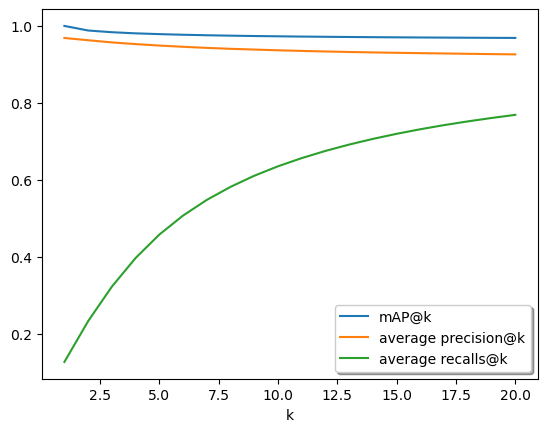

In [110]:
plt.plot(k,stat['mAP'], label='mAP@k')
plt.plot(k,stat['average precision'], label='average precision@k')
plt.plot(k,stat['average recalls'], label='average recalls@k')
plt.legend(loc='best', shadow=True, fancybox=True)
plt.xlabel('k')